# Load observed link flows

In [1]:
using JSON
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_MA_journal
@pyimport GLS_Apr_weekday_PM_journal

In [2]:
numNodes = Compute_Jacobian_MA_journal.numNodes;
numLinks = Compute_Jacobian_MA_journal.numLinks;
numODpairs = Compute_Jacobian_MA_journal.numODpairs;
numZones = Compute_Jacobian_MA_journal.numZones
od_pairs = Compute_Jacobian_MA_journal.od_pairs;
link_list_js = Compute_Jacobian_MA_journal.link_list_js;
link_length_list = Compute_Jacobian_MA_journal.link_length_list;

In [3]:
include("../Julia_files/initia_data.jl");
include("prepare_data_MA_journal.jl");
include("extract_data_Apr_PM_MA_journal.jl");
include("extract_data_Apr_weekend_MA_journal.jl");

In [4]:
flow_observ = GLS_Apr_weekday_PM_journal.x_;

# Load pre-calculated socially-optimal link flows

In [5]:
tapSocialFlowVecDictAprPM = readstring("../temp_files/tapSocialFlowVecDict_Apr_PM_journal.json");
tapSocialFlowVecDictAprPM = JSON.parse(tapSocialFlowVecDictAprPM);

In [6]:
tapSocialFlowVecDictAprWeekend = readstring("../temp_files/tapSocialFlowVecDict_Apr_weekend_journal.json");
tapSocialFlowVecDictAprWeekend = JSON.parse(tapSocialFlowVecDictAprWeekend);

In [7]:
tapSocialFlowVecDictApr = Dict{}()

for key in keys(tapSocialFlowVecDictAprPM)
    tapSocialFlowVecDictApr[key] = tapSocialFlowVecDictAprPM[key]
end

for key in keys(tapSocialFlowVecDictAprWeekend)
    tapSocialFlowVecDictApr[key] = tapSocialFlowVecDictAprWeekend[key]
end

In [8]:
tapSocialFlowVecDictApr["1"];

In [9]:
flow_observ[:, 1];

# Meta analysis for zone costs

In [10]:
link_label_dict;

In [11]:
link_label_dict_converted = Dict()

for key in keys(link_label_dict)
    link_label_dict_converted[parse(Int, key) + 1] = [parse(Int, split(link_label_dict[key], ',')[1]), 
        parse(Int, split(link_label_dict[key], ',')[2])]
end

In [12]:
link_label_dict_converted;

In [13]:
od_nodesList_dict = GLS_Apr_weekday_PM_journal.od_nodesList_dict;

In [14]:
od_nodesList_dict_converted = Dict()

for key in keys(od_nodesList_dict)
    od_nodesList_dict_converted[key + 1] = od_nodesList_dict[key]
end

In [15]:
od_nodesList_dict_converted;

In [16]:
zone_links_dict = Dict()

for key in keys(od_nodesList_dict_converted)
    link_list = []
    for link_idx in keys(link_label_dict_converted)
        if link_label_dict_converted[link_idx][1] in od_nodesList_dict_converted[key] ||
            link_label_dict_converted[link_idx][2] in od_nodesList_dict_converted[key]
            push!(link_list, link_idx)
        end
    end
    zone_links_dict[key] = link_list
end

In [17]:
zone_links_dict;

## Zone cost definition:
Let $\mathcal{A}_i$ denote the link set related to zone $i$ (each link in $\mathcal{A}_i$ has at least one node contained in zone $i$). Then the total users' cost for zone $i$ is
$${C_i} = \sum\limits_{a \in {\mathcal{A}_i}} {{{x_a}} {{t_a}\left( x_a \right)} } $$

In [18]:
function usersObj(fcoeffs, free_flow_time, capacity, linkFlowVec, linkIndices)
    objVal = sum([sum([free_flow_time[a] * fcoeffs[j] * linkFlowVec[a]^j / capacity[a]^(j-1) 
            for j = 1:length(fcoeffs)]) for a in linkIndices])
    return objVal
end

usersObj (generic function with 1 method)

## Scenario 1: weekdays of April 2012, PM period

In [19]:
deg = 8;
c = 0.5;
lam = 10000.0;

coeffs_dict_Apr_PM_ = readstring("../temp_files/coeffs_dict_Apr_PM.json");
coeffs_dict_Apr_PM_ = JSON.parse(coeffs_dict_Apr_PM_);
fcoeffs_Apr_PM = coeffs_dict_Apr_PM_["($(deg),$(c),$(lam),1)"];

In [20]:
free_flow_time_Apr_PM = ta_data_Apr_PM.free_flow_time;
capacity_Apr_PM = ta_data_Apr_PM.capacity;

In [21]:
# calculate costs for zones, 4/18/2012, PM period

zone_cost_dict_Apr_PM_user = Dict();
zone_cost_dict_Apr_PM_social = Dict();

week_day_Apr_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30];

for day in week_day_Apr_list 
    for zone = 1:length(zone_links_dict)
        # user-centric policy
        zone_cost_dict_Apr_PM_user[(day, zone)] = usersObj(fcoeffs_Apr_PM, free_flow_time_Apr_PM, 
        capacity_Apr_PM, flow_observ[:, day], zone_links_dict[zone])

        # system-centric policy
        zone_cost_dict_Apr_PM_social[(day, zone)] = usersObj(fcoeffs_Apr_PM, free_flow_time_Apr_PM, 
        capacity_Apr_PM, tapSocialFlowVecDictApr["$(day)"], zone_links_dict[zone])
    end
end

In [22]:
day = 2

for zone = 1:length(zone_links_dict)
    println([zone_cost_dict_Apr_PM_user[(day, zone)], zone_cost_dict_Apr_PM_social[(day, zone)]])
end

[1312.61,667.915]
[978.947,522.849]
[1045.83,1113.98]
[2954.62,1741.97]
[1495.21,818.036]
[2748.1,1183.17]
[574.658,182.071]
[2734.22,1052.42]
[5532.27,1586.0]
[1775.17,2048.27]
[2354.74,1751.03]
[9982.64,1494.96]
[23200.0,6053.19]
[1815.65,990.856]
[16343.4,8647.51]
[1535.65,1512.7]
[803.91,1252.33]
[6285.38,3784.8]
[887.43,641.53]
[2170.15,2180.43]
[3534.67,3094.2]
[2011.06,575.963]
[1069.63,848.49]
[531.458,1120.99]
[422.426,410.731]
[1179.06,859.631]
[143.824,118.288]
[397.663,624.802]
[367.941,839.638]
[2764.07,3740.89]
[474.564,613.387]
[571.678,730.663]
[245.231,268.171]
[636.375,749.022]


## Scenario 2: weekends of April 2012, PM period

In [23]:
deg = 6
c = 0.5
lam = 10000.0

coeffs_dict_Apr_weekend_ = readstring("../temp_files/coeffs_dict_Apr_weekend.json");
coeffs_dict_Apr_weekend_ = JSON.parse(coeffs_dict_Apr_weekend_);
fcoeffs_Apr_weekend = coeffs_dict_Apr_weekend_["($(deg),$(c),$(lam),1)"];

In [24]:
free_flow_time_Apr_weekend = ta_data_Apr_weekend.free_flow_time;
capacity_Apr_weekend = ta_data_Apr_weekend.capacity;

In [25]:
# calculate costs for zones, weekends of April 2012, PM period

zone_cost_dict_Apr_weekend_user = Dict();
zone_cost_dict_Apr_weekend_social = Dict();

weekend_Apr_list = [1, 7, 8, 14, 15, 21, 22, 28, 29]

for day in weekend_Apr_list
    for zone = 1:length(zone_links_dict)
        # user-centric policy
        zone_cost_dict_Apr_weekend_user[(day, zone)] = usersObj(fcoeffs_Apr_weekend, 
        free_flow_time_Apr_weekend, capacity_Apr_weekend, flow_observ[:, day], zone_links_dict[zone])

        # system-centric policy
        zone_cost_dict_Apr_weekend_social[(day, zone)] = usersObj(fcoeffs_Apr_weekend, 
        free_flow_time_Apr_weekend, capacity_Apr_weekend, tapSocialFlowVecDictApr["$(day)"], 
        zone_links_dict[zone])
    end  
end

In [26]:
# day = 1

# for zone = 1:length(zone_links_dict)
#     println([zone_cost_dict_Apr_weekend_user[(day, zone)], zone_cost_dict_Apr_weekend_social[(day, zone)]])
# end

## Visualization of zone costs (user-centric vs. system-centric)

### Three observations can be made: 

#### (1) Overall, most zone costs would be reduced when switching from user-centric policy to system-centric policy.

#### (2) In general, the zone costs for weekends are less than their counterparts for weekdays; this is consistent with intuition.

#### (3) The decrease seems more constant for all zones in weekends than in weekdays, meaning it is easier to optimize the network for weekends than for weekdays; this is again consistent with intuition. 

In [27]:
using PyPlot

## Plots for weekdays

### Example: PM period, 4/18/2012, Wednesday

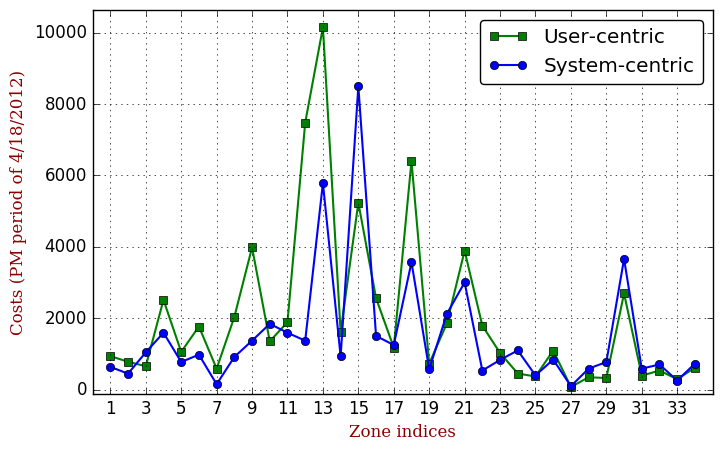

In [28]:
for day in [18]

    fig = figure(figsize=(8,4.8))

    zone = 1:length(zone_links_dict)

    zone_cost_vec_Apr_PM_user = [zone_cost_dict_Apr_PM_user[(day, zone_idx)] for zone_idx in zone]
    zone_cost_vec_Apr_PM_social = [zone_cost_dict_Apr_PM_social[(day, zone_idx)] for zone_idx in zone]

    plot(zone, zone_cost_vec_Apr_PM_user, "s-g", linewidth=1.5, label="User-centric")
    plot(zone, zone_cost_vec_Apr_PM_social, "o-b", linewidth=1.5, label="System-centric")

    # legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
    legend(loc=0, fancybox="true") 

    grid("on")

    xlim(0, 35)
    xticks(1:2:34)
    ylim(-100, maximum([maximum(zone_cost_vec_Apr_PM_user), maximum(zone_cost_vec_Apr_PM_social)])+500)

    font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>12)

    xlabel("Zone indices", fontdict=font1)
    ylabel("Costs (PM period of 4/$(day)/2012)", fontdict=font1)

    savefig("./results/Zone_costs_Apr_$(day)_journal.pdf")
    
end

## Plots for weekends

### Example: PM period, 4/15/2012, Sunday

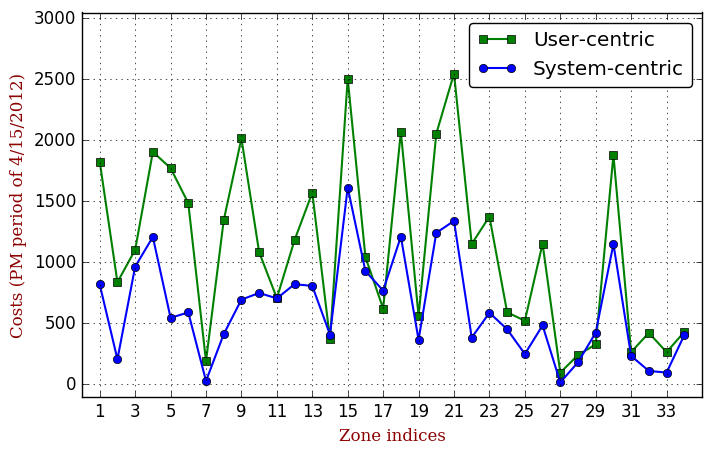

In [29]:
for day in [15]

    fig = figure(figsize=(8,4.8))

    zone = 1:length(zone_links_dict)

    zone_cost_vec_Apr_weekend_user = [zone_cost_dict_Apr_weekend_user[(day, zone_idx)] for zone_idx in zone]
    zone_cost_vec_Apr_weekend_social = [zone_cost_dict_Apr_weekend_social[(day, zone_idx)] for zone_idx in zone]

    plot(zone, zone_cost_vec_Apr_weekend_user, "s-g", linewidth=1.5, label="User-centric")
    plot(zone, zone_cost_vec_Apr_weekend_social, "o-b", linewidth=1.5, label="System-centric")

    # legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
    legend(loc=0, fancybox="true") 

    grid("on")

    xlim(0, 35)
    xticks(1:2:34)
    ylim(-100, maximum([maximum(zone_cost_vec_Apr_weekend_user), 
        maximum(zone_cost_vec_Apr_weekend_social)])+500)

    font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>12)

    xlabel("Zone indices", fontdict=font1)
    ylabel("Costs (PM period of 4/$(day)/2012)", fontdict=font1)

    savefig("./results/Zone_costs_Apr_$(day)_journal.pdf")
    
end

# Meta analysis for link flows

## maximum and minimum link flows

In [30]:
max_link_flow_social_dict = Dict()
min_link_flow_social_dict = Dict()

for day = 1:30
    # maximum link flow (social)
    max_link_flow_social_dict[day] = findmax(tapSocialFlowVecDictApr["$(day)"])

    # minimum link flow (social)
    min_link_flow_social_dict[day] = findmin(tapSocialFlowVecDictApr["$(day)"])
end

In [31]:
max_link_flow_user_dict = Dict()
min_link_flow_user_dict = Dict()

for day = 1:30
    # maximum link flow (user)
    max_link_flow_user_dict[day] = findmax(flow_observ[:, day])

    # minimum link flow (user)
    min_link_flow_user_dict[day] = findmin(flow_observ[:, day])
end

In [32]:
max_link_flow_social_dict

Dict{Any,Any} with 30 entries:
  18 => (7684.86,98)
  30 => (7688.47,98)
  2  => (7687.65,98)
  16 => (6977.28,98)
  11 => (7691.85,98)
  21 => (2701.49,128)
  7  => (2789.31,128)
  9  => (7687.65,98)
  25 => (7688.47,98)
  10 => (7691.85,98)
  26 => (7688.47,98)
  29 => (2669.78,128)
  19 => (6964.89,98)
  17 => (7695.92,98)
  8  => (2789.31,128)
  22 => (2701.49,128)
  6  => (6979.82,98)
  24 => (7682.25,98)
  4  => (7687.65,98)
  3  => (7687.65,98)
  28 => (2669.78,128)
  5  => (7687.65,98)
  20 => (6964.89,98)
  23 => (7684.86,98)
  13 => (7695.92,98)
  ⋮  => ⋮

In [33]:
max_link_flow_user_dict

Dict{Any,Any} with 30 entries:
  18 => (5694.16,156)
  30 => (8348.15,39)
  2  => (6758.83,89)
  16 => (4819.28,39)
  11 => (6351.09,103)
  21 => (2120.63,78)
  7  => (2311.83,104)
  9  => (5451.36,89)
  25 => (6239.48,103)
  10 => (7159.62,89)
  26 => (5917.86,60)
  29 => (2643.14,30)
  19 => (4705.84,89)
  17 => (4848.33,147)
  8  => (2932.75,30)
  22 => (2697.52,30)
  6  => (3703.43,85)
  24 => (6028.75,89)
  4  => (6598.19,89)
  3  => (6483.92,95)
  28 => (1868.09,30)
  5  => (6866.57,156)
  20 => (3849.83,85)
  23 => (7285.14,155)
  13 => (4991.72,156)
  ⋮  => ⋮

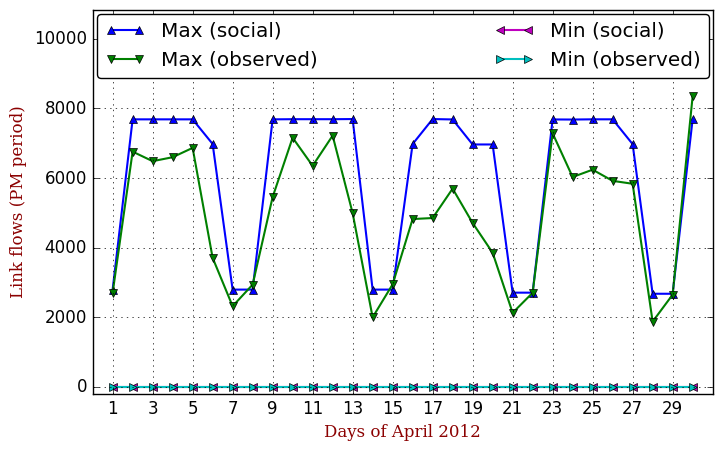

In [34]:
fig = figure(figsize=(8,4.8))

day = 1:length(max_link_flow_social_dict)

max_link_flow_social_vec = [max_link_flow_social_dict[idx][1] for idx in day]
min_link_flow_social_vec = [min_link_flow_social_dict[idx][1] for idx in day]

max_link_flow_user_vec = [max_link_flow_user_dict[idx][1] for idx in day]
min_link_flow_user_vec = [min_link_flow_user_dict[idx][1] for idx in day]

plot(day, max_link_flow_social_vec, "^-b", linewidth=1.5, label="Max (social)")
plot(day, max_link_flow_user_vec, "v-g", linewidth=1.5, label="Max (observed)")

plot(day, min_link_flow_social_vec, "<-m", linewidth=1.5, label="Min (social)")
plot(day, min_link_flow_user_vec, ">-c", linewidth=1.5, label="Min (observed)")

# legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2) 

grid("on")

xlim(0, 31)
xticks(1:2:30)
ylim(-200, maximum([maximum(max_link_flow_social_vec), maximum(max_link_flow_user_vec)])+2500)

font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>12)

xlabel("Days of April 2012", fontdict=font1)
ylabel("Link flows (PM period)", fontdict=font1)

savefig("./results/max_min_link_flow_Apr_journal.pdf")

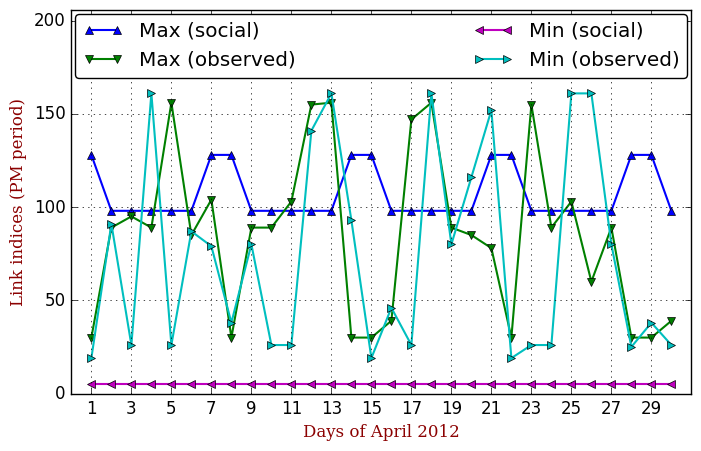

In [35]:
# fig = figure(figsize=(11,40))
fig = figure(figsize=(8,4.8))

day = 1:length(max_link_flow_social_dict)

max_link_flow_social_vec = [max_link_flow_social_dict[idx][2] for idx in day]
min_link_flow_social_vec = [min_link_flow_social_dict[idx][2] for idx in day]

max_link_flow_user_vec = [max_link_flow_user_dict[idx][2] for idx in day]
min_link_flow_user_vec = [min_link_flow_user_dict[idx][2] for idx in day]

plot(day, max_link_flow_social_vec, "^-b", linewidth=1.5, label="Max (social)")
plot(day, max_link_flow_user_vec, "v-g", linewidth=1.5, label="Max (observed)")

plot(day, min_link_flow_social_vec, "<-m", linewidth=1.5, label="Min (social)")
plot(day, min_link_flow_user_vec, ">-c", linewidth=1.5, label="Min (observed)")

# legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2) 

grid("on")

xlim(0, 31)
xticks(1:2:30)
ylim(0, maximum([maximum(max_link_flow_social_vec), maximum(max_link_flow_user_vec)]) + 50)
# yticks(4:164)

font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>12)

xlabel("Days of April 2012", fontdict=font1)
ylabel("Link indices (PM period)", fontdict=font1)

savefig("./results/max_min_link_index_Apr_journal.pdf")

# Meta analysis for link congestion

Based on Greenshield's model, we define the $\textbf{Congestion Metric}$ for link $a$ as 
$$C{M_a} = \left\{ \begin{gathered}
  1 - \frac{{{x_a}}}{{{m_a}}} = 1 - 4\left[ {\frac{{{v_a}}}{{v_a^0}} - {{\left( {\frac{{{v_a}}}{{v_a^0}}} \right)}^2}} \right],{\text{ if }}0 \leq {v_a} < \frac{{v_a^0}}{2}, \hfill \\
  0,{\text{ if }}{v_a} \geq \frac{{v_a^0}}{2}, \hfill \\ 
\end{gathered}  \right.$$
where $x_a$ and $m_a$ are the $\textbf{link flow}$ and $\textbf{flow capacity}$ respectively, and $v_a$ (resp., $v_a^0$) is the $\textbf{observed speed}$ (resp., $\textbf{free-flow speed}$) on link $a$. Note that in our analysis, we always have $CM_a \in [0,1]$; in particular, when ${v_a} \geq \frac{{v_a^0}}{2}$, we define $CM_a = 0$, meaning the congestion (if any) on link $a$ could be ignored. In our calculations, we take $v_a^0 = {s_a}\big/{t_a^0},$ where $s_a$ is the $\textbf{length}$ of link $a$ and $t_a^0$ is the $\textbf{free-flow travel time}$ of link $a$.